In [1]:
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pywt
from tqdm import tqdm
from sklearn.preprocessing import (
    PowerTransformer,
    StandardScaler,
    label_binarize
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)
sns.set_theme(style="whitegrid")


In [2]:
df=pd.read_csv("Combined Data\Combined_dataset.csv")

<>:1: SyntaxWarning: invalid escape sequence '\C'
<>:1: SyntaxWarning: invalid escape sequence '\C'
C:\Users\O\AppData\Local\Temp\ipykernel_14372\468677050.py:1: SyntaxWarning: invalid escape sequence '\C'
  df=pd.read_csv("Combined Data\Combined_dataset.csv")
C:\Users\O\AppData\Local\Temp\ipykernel_14372\468677050.py:1: SyntaxWarning: invalid escape sequence '\C'
  df=pd.read_csv("Combined Data\Combined_dataset.csv")


FileNotFoundError: [Errno 2] No such file or directory: 'Combined Data\\Combined_dataset.csv'

In [ ]:
df.head()

,Country,Area,Waterbody Type,Date,Ammonia (mg/l),Biochemical Oxygen Demand (mg/l),Dissolved Oxygen (mg/l),Orthophosphate (mg/l),pH (ph units),Temperature (cel),Nitrogen (mg/l),Nitrate (mg/l),CCME_Values,CCME_WQI
0,Canada,SE649035-145565,River,12-01-1974,0.059248,1.30,8.1500,0.011917,8.07500,9.885,0.343917,11.73155,100.0,Excellent
1,Canada,SE649035-145565,River,12-01-1975,0.039821,1.38,7.8000,0.009417,7.73333,10.150,0.449083,11.82009,100.0,Excellent
2,Canada,SE649035-145565,River,12-01-1976,0.031341,2.23,7.8000,0.011000,7.46667,10.235,0.220750,14.87472,100.0,Excellent
3,Canada,SE649035-145565,River,12-01-1977,0.020501,1.61,8.1500,0.012333,7.78333,11.116,0.572250,15.89293,100.0,Excellent
4,Canada,SE649035-145565,River,12-01-1978,0.020023,1.64,4.3708,0.006182,7.10000,7.068,0.371091,15.22888,100.0,Excellent


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2827977 entries, 0 to 2827976
Data columns (total 14 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   Country                           object 
 1   Area                              object 
 2   Waterbody Type                    object 
 3   Date                              object 
 4   Ammonia (mg/l)                    float64
 5   Biochemical Oxygen Demand (mg/l)  float64
 6   Dissolved Oxygen (mg/l)           float64
 7   Orthophosphate (mg/l)             float64
 8   pH (ph units)                     float64
 9   Temperature (cel)                 float64
 10  Nitrogen (mg/l)                   float64
 11  Nitrate (mg/l)                    float64
 12  CCME_Values                       float64
 13  CCME_WQI                          object 
dtypes: float64(9), object(5)
memory usage: 302.1+ MB


In [ ]:
df.isnull().sum()

Country                             0
Area                                0
Waterbody Type                      0
Date                                0
Ammonia (mg/l)                      0
Biochemical Oxygen Demand (mg/l)    0
Dissolved Oxygen (mg/l)             0
Orthophosphate (mg/l)               0
pH (ph units)                       0
Temperature (cel)                   0
Nitrogen (mg/l)                     0
Nitrate (mg/l)                      0
CCME_Values                         0
CCME_WQI                            0
dtype: int64

In [ ]:
df["CCME_WQI"].value_counts()

CCME_WQI
Good         1033709
Excellent    1020710
Marginal      328734
Fair          317856
Poor          126968
Name: count, dtype: int64

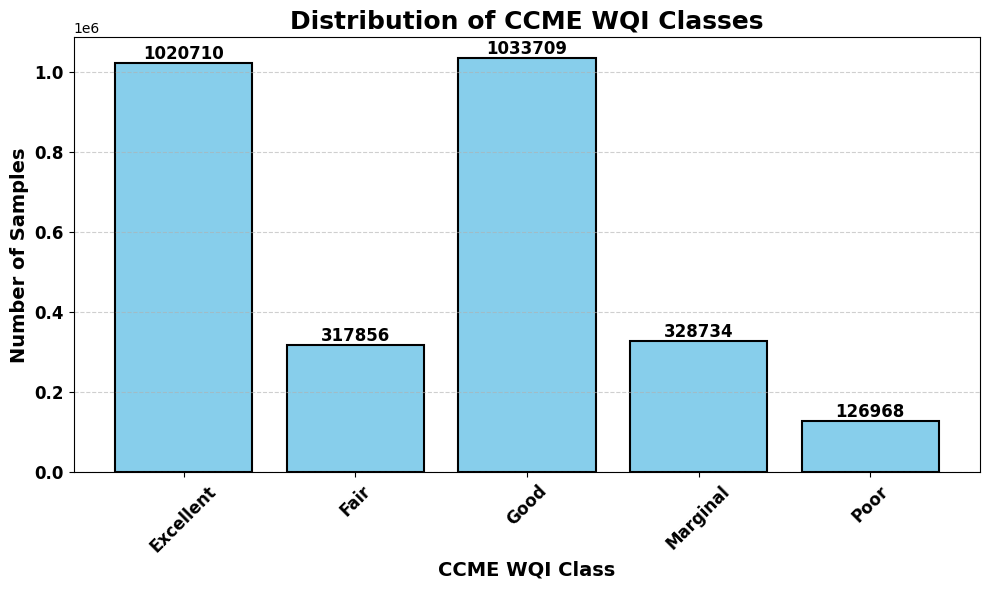

In [ ]:
 
distribution = df["CCME_WQI"].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bars = plt.bar(
    distribution.index,
    distribution.values,
    color="skyblue",
    edgecolor="black",
    linewidth=1.5
)

 
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,   
        height + 0.5,                      
        f'{int(height)}',                 
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )

plt.title("Distribution of CCME WQI Classes", fontsize=18, fontweight="bold")
plt.xlabel("CCME WQI Class", fontsize=14, fontweight="bold")
plt.ylabel("Number of Samples", fontsize=14, fontweight="bold")
plt.xticks(fontsize=12, fontweight="bold", rotation=45)
plt.yticks(fontsize=12, fontweight="bold")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
corr_data=df.select_dtypes(include="number").corr()

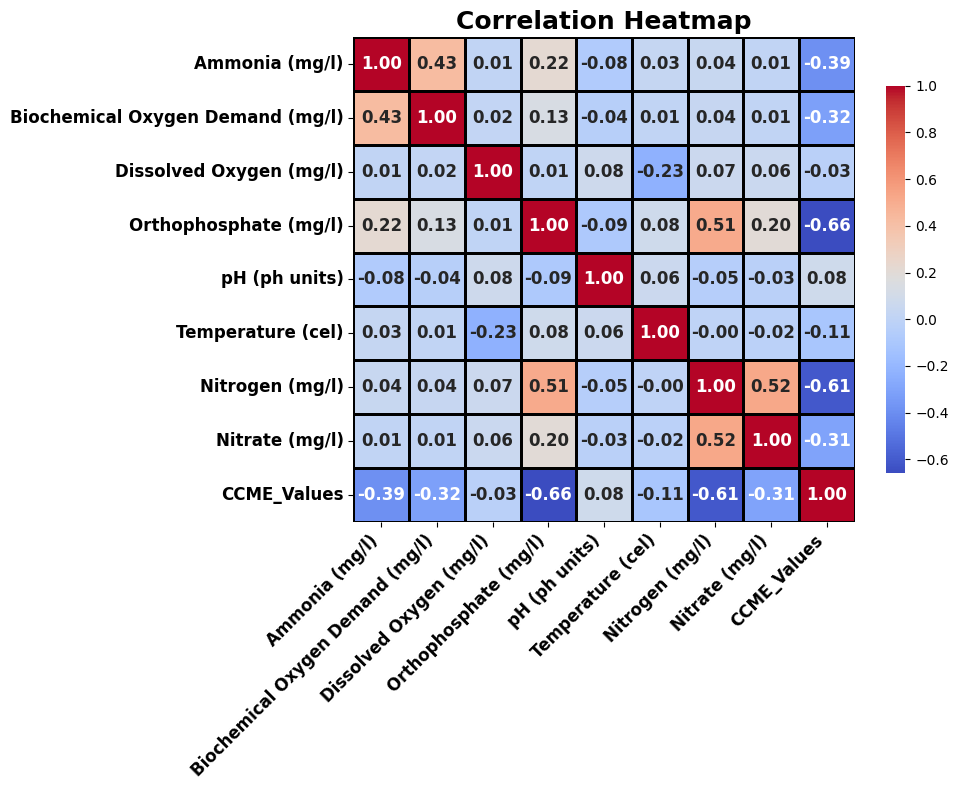

In [ ]:
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    corr_data,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    annot_kws={"size": 12, "weight": "bold"},
    linewidths=1,
    linecolor="black",
    cbar_kws={"shrink": 0.8}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    fontsize=12,
    fontweight="bold",
    rotation=45,
    ha="right"
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    fontsize=12,
    fontweight="bold",
    rotation=0
)
plt.title("Correlation Heatmap", fontsize=18, fontweight="bold")
plt.tight_layout()
plt.show()


In [ ]:
df.duplicated().sum()

np.int64(9971)

In [ ]:
df[df.duplicated()]
duplicates_grouped = df.groupby(list(df.columns)).size().reset_index(name='count')
duplicates_grouped[duplicates_grouped['count'] > 1]

,Country,Area,Waterbody Type,Date,Ammonia (mg/l),Biochemical Oxygen Demand (mg/l),Dissolved Oxygen (mg/l),Orthophosphate (mg/l),pH (ph units),Temperature (cel),Nitrogen (mg/l),Nitrate (mg/l),CCME_Values,CCME_WQI,count
94,Canada,CHRW-1339,River,12-01-2005,0.051060,0.930000,10.2160,0.0127,8.3167,10.9500,1.664290,5.245995,100.000000,Excellent,2
95,Canada,CHRW-1345,River,12-01-1999,0.137558,1.520000,10.5250,0.0124,8.3133,19.6667,1.245670,4.249920,100.000000,Excellent,2
96,Canada,CHRW-1345,River,12-01-2000,0.121072,1.500000,10.2500,0.1022,8.1975,11.6583,0.636642,4.382730,91.774842,Good,2
97,Canada,CHRW-1345,River,12-01-2001,0.177699,1.545390,9.0750,0.0230,8.1725,11.4250,12.500000,13.731226,100.000000,Excellent,2
98,Canada,CHRW-1345,River,12-01-2002,0.052107,0.558333,10.2167,0.0114,8.1700,10.7583,0.636364,5.091050,100.000000,Excellent,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2817361,USA,Yuba,River,16-01-1962,0.021000,1.600000,9.8700,0.0400,7.8000,11.1000,0.400000,0.900000,100.000000,Excellent,2
2817416,USA,Yuba,River,16-12-1976,0.021000,1.600000,9.8700,0.0400,7.8000,11.1000,0.400000,0.900000,100.000000,Excellent,2
2817527,USA,Yuba,River,20-02-1962,0.021000,1.600000,9.8700,0.0400,7.3000,11.1000,0.400000,0.900000,100.000000,Excellent,2
2817531,USA,Yuba,River,20-02-2003,0.021000,1.600000,9.8700,0.0400,7.8000,1.4000,0.400000,0.900000,100.000000,Excellent,2


In [ ]:
df.isna().sum()

Country                             0
Area                                0
Waterbody Type                      0
Date                                0
Ammonia (mg/l)                      0
Biochemical Oxygen Demand (mg/l)    0
Dissolved Oxygen (mg/l)             0
Orthophosphate (mg/l)               0
pH (ph units)                       0
Temperature (cel)                   0
Nitrogen (mg/l)                     0
Nitrate (mg/l)                      0
CCME_Values                         0
CCME_WQI                            0
dtype: int64

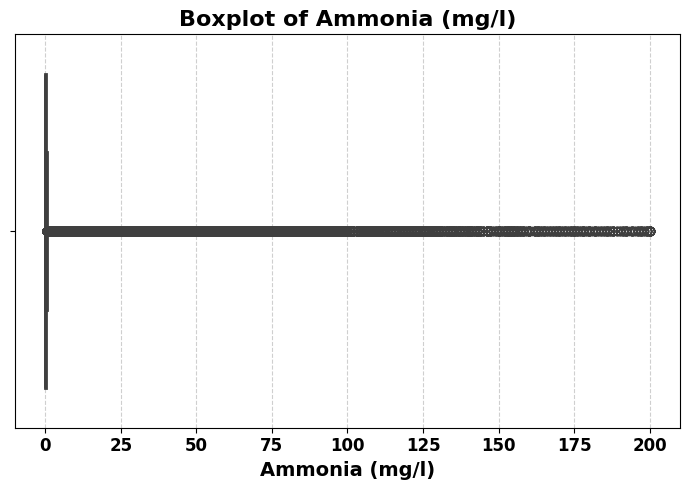

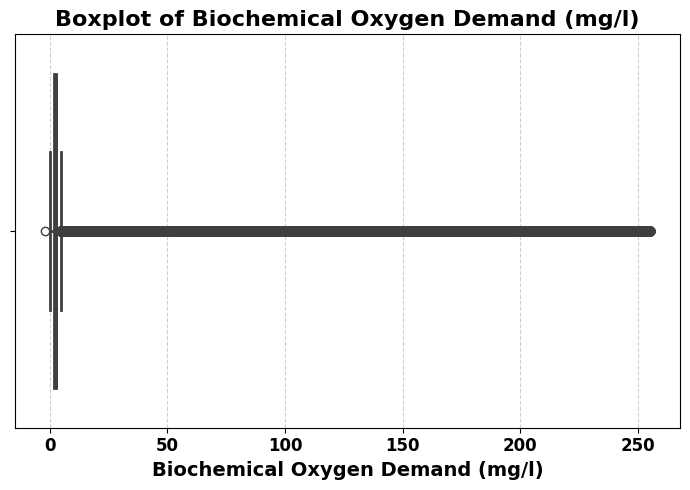

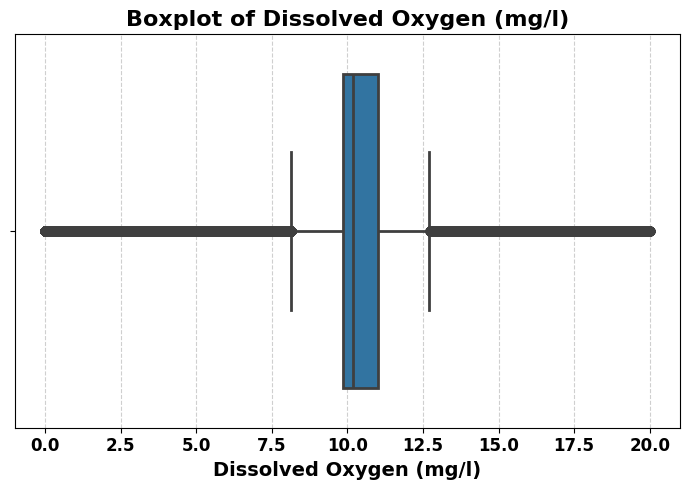

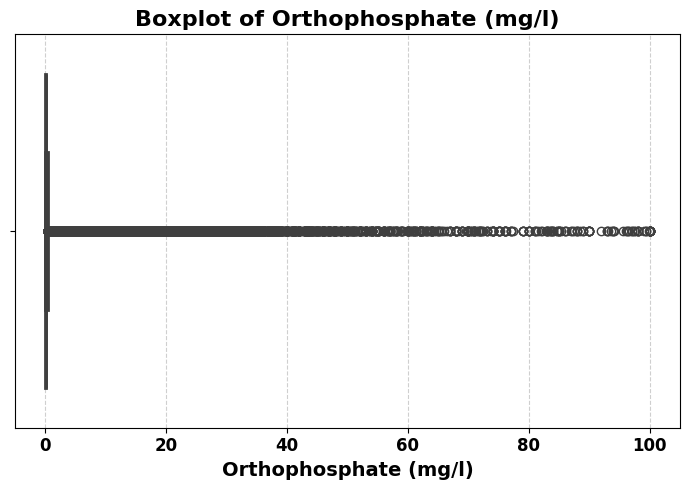

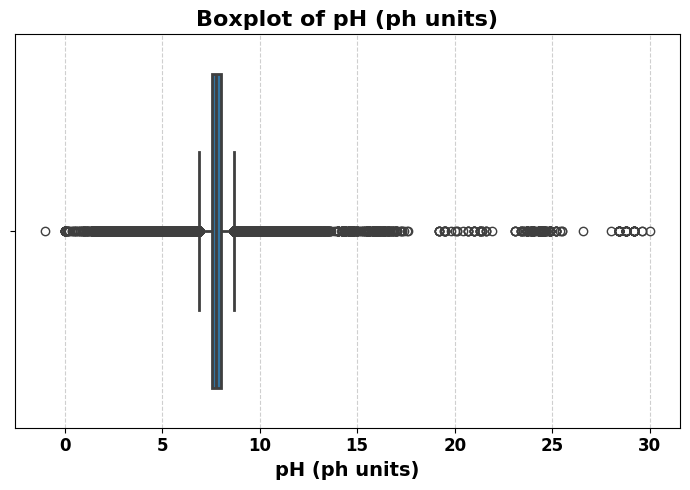

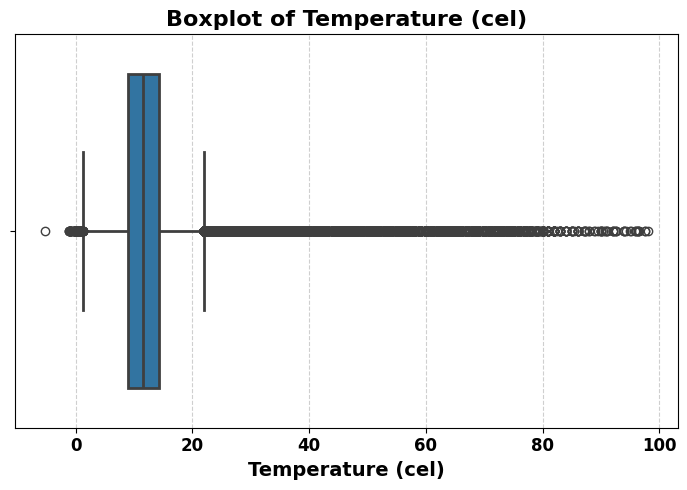

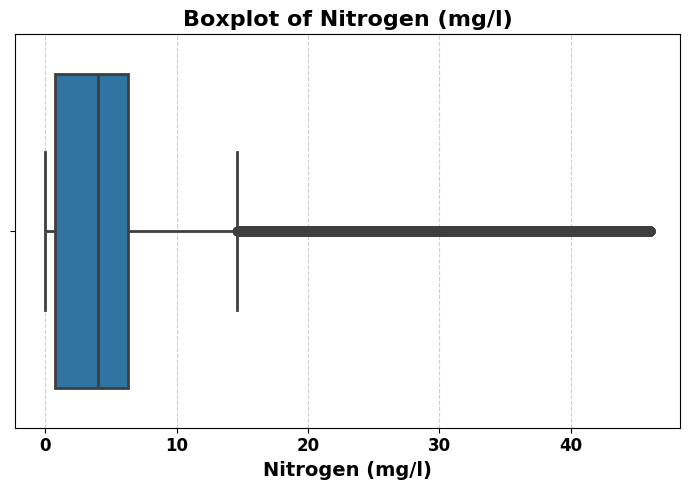

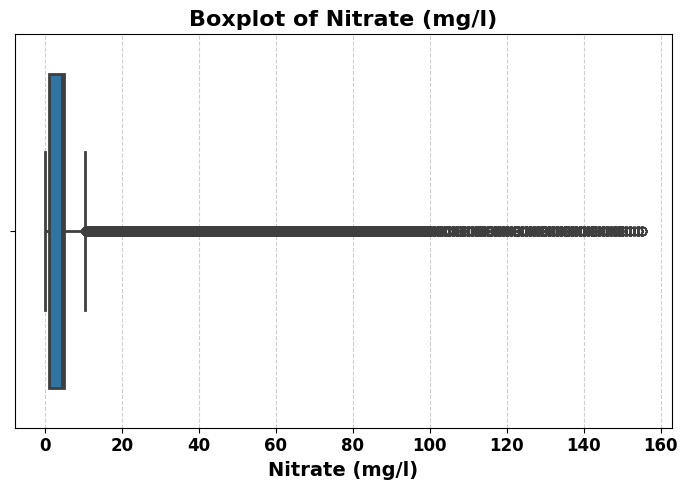

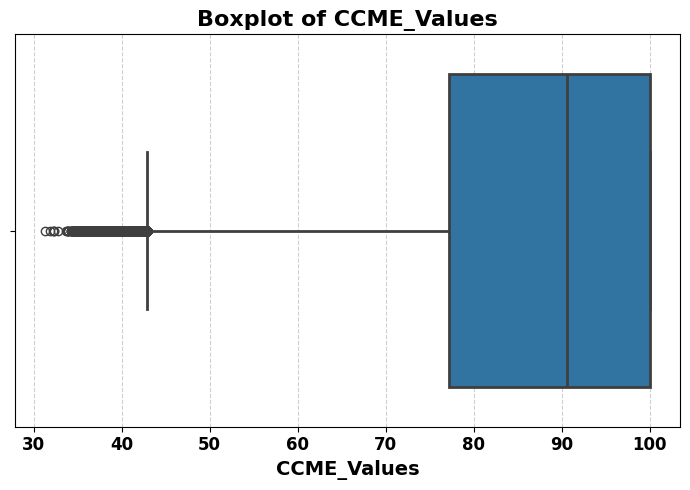

In [ ]:
numeric_cols = df.select_dtypes(include="number").columns

for col in numeric_cols:
    plt.figure(figsize=(7, 5))

    ax = sns.boxplot(
        x=df[col],
        linewidth=2
    )
    ax.set_title(
        f"Boxplot of {col}",
        fontsize=16,
        fontweight="bold"
    )
    ax.set_xlabel(
        col,
        fontsize=14,
        fontweight="bold"
    )
    ax.tick_params(axis='x', labelsize=12)
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')

   
    ax.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


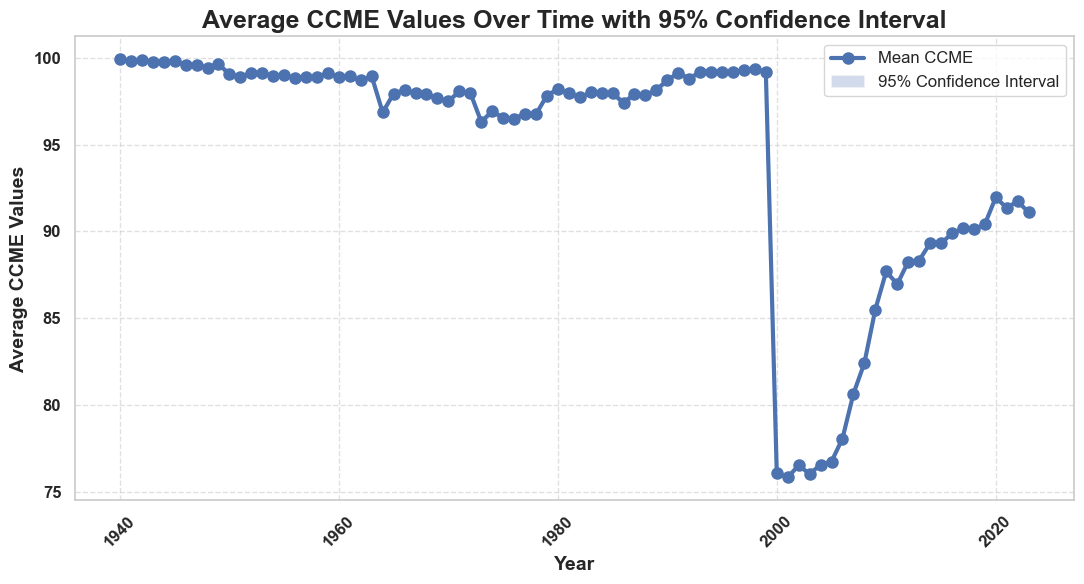

In [ ]:
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
df["CCME_Values"] = pd.to_numeric(df["CCME_Values"], errors="coerce")
df["Year"] = df["Date"].dt.year
agg = df.groupby("Year")["CCME_Values"].agg(["mean", "std", "count"]).dropna()
agg["sem"] = agg["std"] / np.sqrt(agg["count"])
agg["ci95_low"] = agg["mean"] - 1.96 * agg["sem"]
agg["ci95_high"] = agg["mean"] + 1.96 * agg["sem"]
plt.figure(figsize=(11, 6))
plt.plot(
    agg.index,
    agg["mean"],
    marker="o",
    linewidth=3,
    markersize=8,
    label="Mean CCME"
)

plt.fill_between(
    agg.index,
    agg["ci95_low"],
    agg["ci95_high"],
    alpha=0.25,
    label="95% Confidence Interval"
) 
plt.xlabel("Year", fontsize=14, fontweight="bold")
plt.ylabel("Average CCME Values", fontsize=14, fontweight="bold")
plt.title(
    "Average CCME Values Over Time with 95% Confidence Interval",
    fontsize=18,
    fontweight="bold"
)
plt.xticks(fontsize=12, fontweight="bold", rotation=45)
plt.yticks(fontsize=12, fontweight="bold") 
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


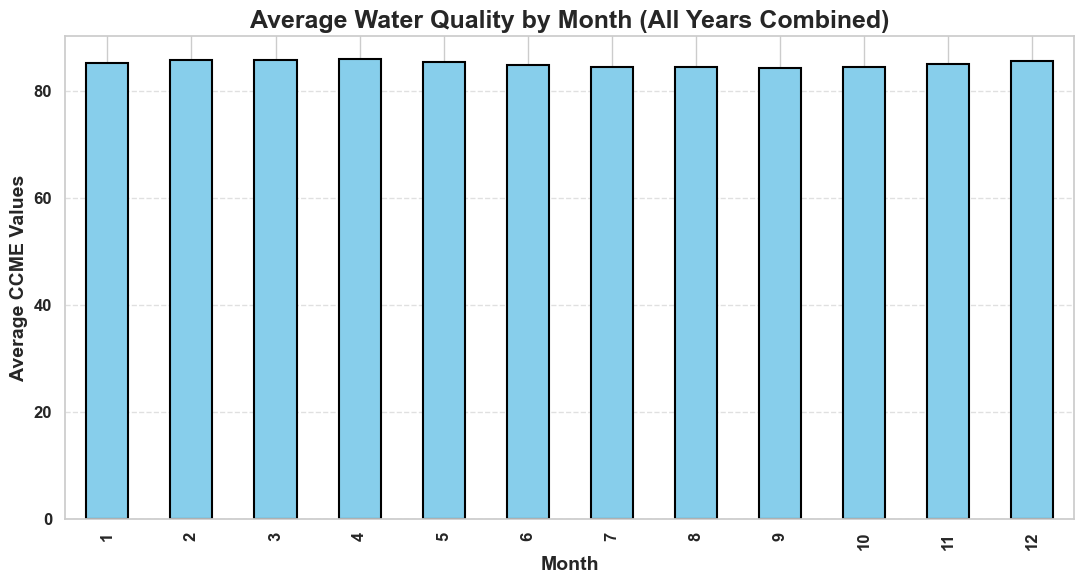

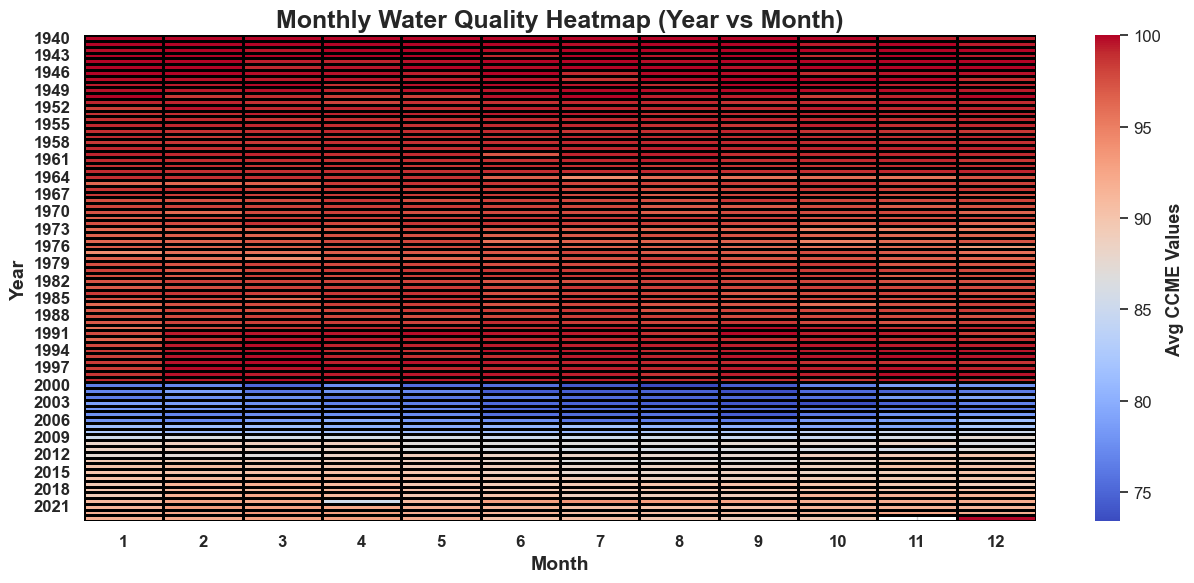

In [ ]:
 
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
df["CCME_Values"] = pd.to_numeric(df["CCME_Values"], errors="coerce")
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
monthly_quality = df.groupby("Month")["CCME_Values"].mean()
plt.figure(figsize=(11, 6))
ax = monthly_quality.plot(
    kind="bar",
    color="skyblue",
    edgecolor="black",
    linewidth=1.5
) 
ax.set_title(
    "Average Water Quality by Month (All Years Combined)",
    fontsize=18,
    fontweight="bold"
)
ax.set_xlabel("Month", fontsize=14, fontweight="bold")
ax.set_ylabel("Average CCME Values", fontsize=14, fontweight="bold")
 
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
for label in ax.get_xticklabels():
    label.set_fontweight("bold")
for label in ax.get_yticklabels():
    label.set_fontweight("bold")
ax.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()
pivot = df.pivot_table(
    index="Year",
    columns="Month",
    values="CCME_Values",
    aggfunc="mean"
)

plt.figure(figsize=(13, 6))
ax = sns.heatmap(
    pivot,
    cmap="coolwarm",
    annot=False,
    linewidths=0.8,
    linecolor="black",
    cbar_kws={"label": "Avg CCME Values"}
)
ax.set_title(
    "Monthly Water Quality Heatmap (Year vs Month)",
    fontsize=18,
    fontweight="bold"
)
ax.set_xlabel("Month", fontsize=14, fontweight="bold")
ax.set_ylabel("Year", fontsize=14, fontweight="bold")

 
ax.set_xticklabels(
    ax.get_xticklabels(),
    fontsize=12,
    fontweight="bold"
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    fontsize=12,
    fontweight="bold"
)

 
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Avg CCME Values", fontsize=13, fontweight="bold")

plt.tight_layout()
plt.show()


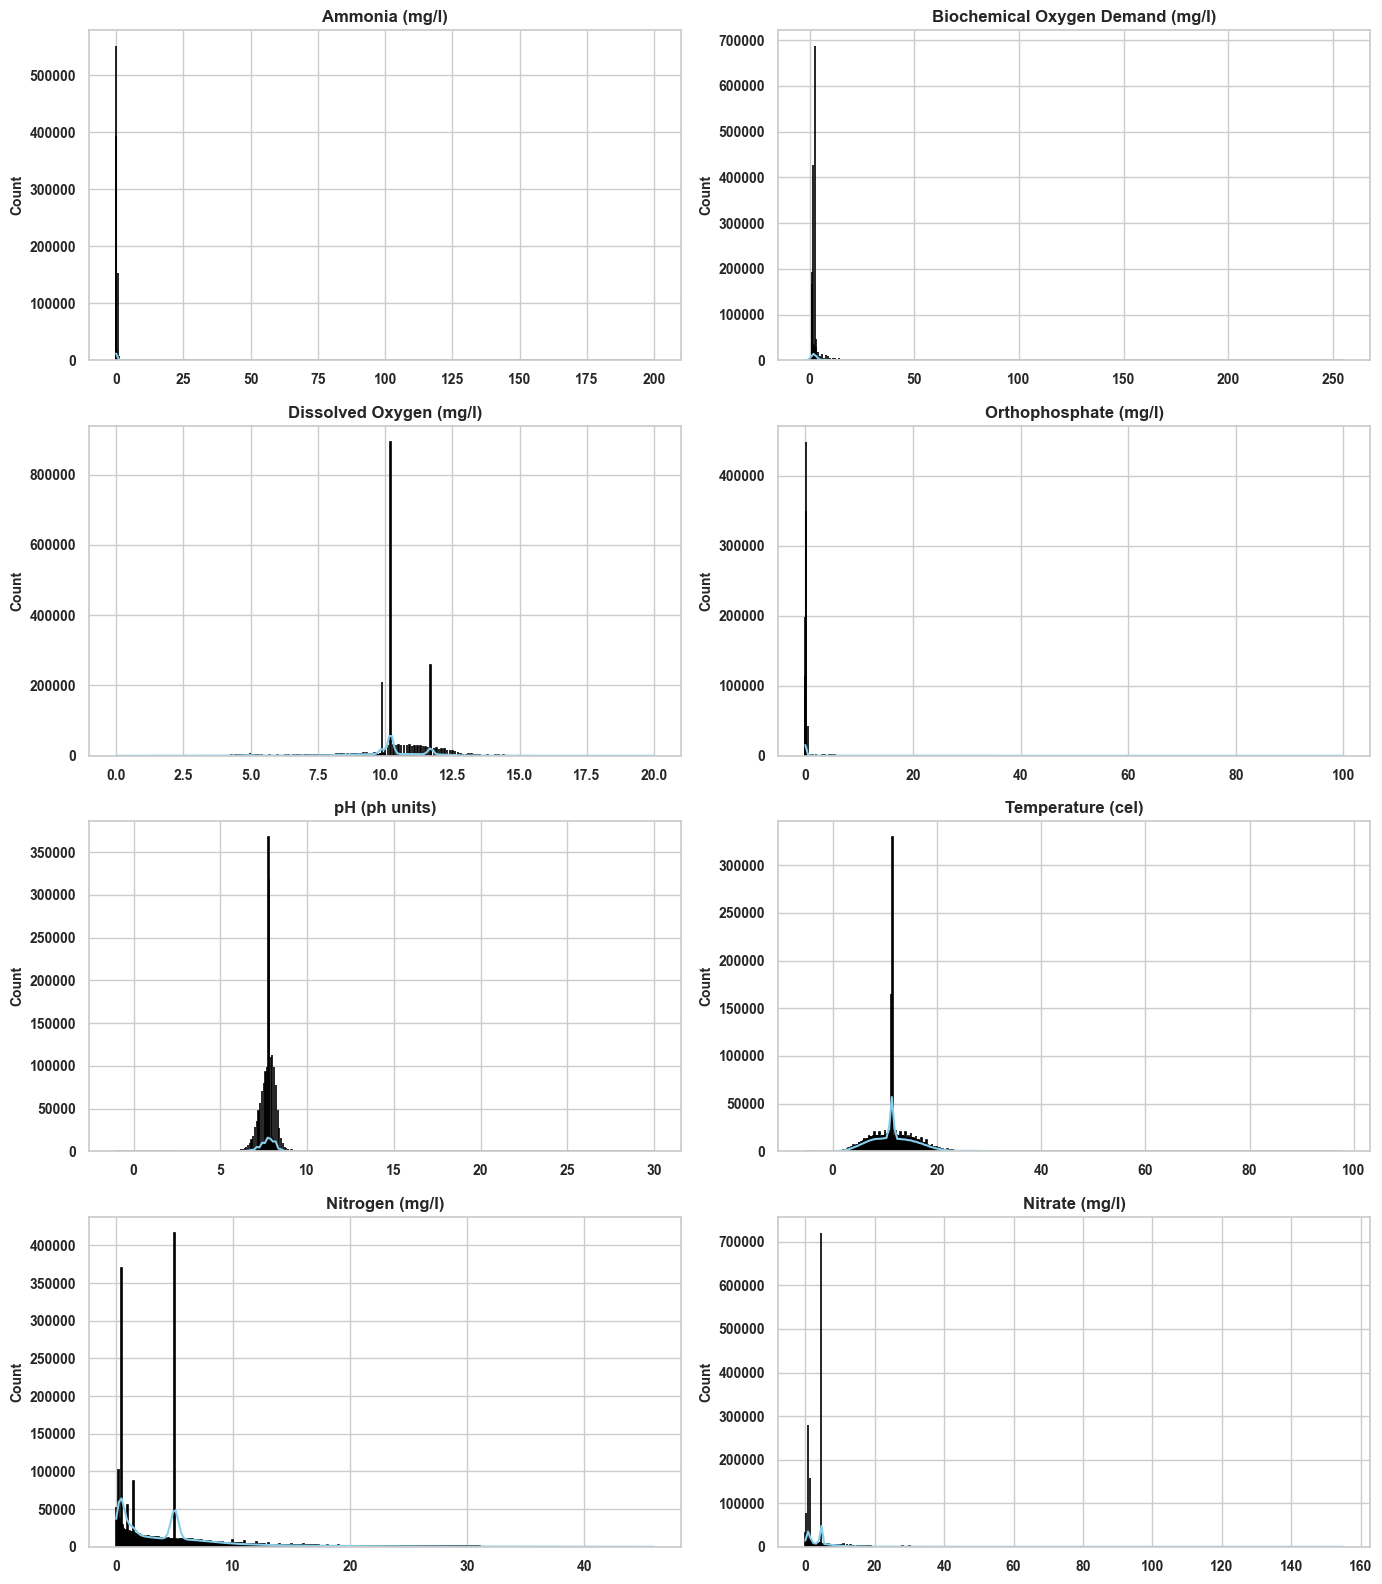

In [ ]:
features = [
    "Ammonia (mg/l)", 
    "Biochemical Oxygen Demand (mg/l)",
    "Dissolved Oxygen (mg/l)", 
    "Orthophosphate (mg/l)",
    "pH (ph units)", 
    "Temperature (cel)", 
    "Nitrogen (mg/l)", 
    "Nitrate (mg/l)"
]

n_rows = 4
n_cols = 2

plt.figure(figsize=(14, 16))
sns.set_theme(style="whitegrid")

for i, col in enumerate(features, 1):    
    plt.subplot(n_rows, n_cols, i)
    
    ax = sns.histplot(
        df[col],
        kde=True,
        color="skyblue",
        edgecolor="black",
        linewidth=1.2
    )
    
 
    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_xlabel("")  
    ax.set_ylabel("Count", fontsize=10, fontweight="bold")
    
 
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    for label in ax.get_yticklabels():
        label.set_fontweight("bold")
    for label in ax.get_xticklabels():
        label.set_fontweight("bold")

plt.tight_layout()   
plt.show()


In [ ]:
 
valid_ranges = {
    "Ammonia (mg/l)": (0, 20),
    "Biochemical Oxygen Demand (mg/l)": (0, 50),
    "Dissolved Oxygen (mg/l)": (2, 30),
    "Orthophosphate (mg/l)": (0, 10),
    "pH (ph units)": (4, 11),
    "Temperature (cel)": (0, 60),
    "Nitrogen (mg/l)": (0, 50),
    "Nitrate (mg/l)": (0, 100),
    "CCME_Values": (0, 100)
}
mask_valid = pd.Series(True, index=df.index)
for col, (low, high) in valid_ranges.items():
    mask_valid &= df[col].between(low, high, inclusive="both")
df_clean = df[mask_valid].copy()
print("Before cleaning:", df.shape[0], "rows")
print("After cleaning:", df_clean.shape[0], "rows")
print("Removed:", df.shape[0] - df_clean.shape[0], "illogical rows")

Before cleaning: 2827977 rows
After cleaning: 2734630 rows
Removed: 93347 illogical rows


In [ ]:
df_clean

,Country,Area,Waterbody Type,Date,Ammonia (mg/l),Biochemical Oxygen Demand (mg/l),Dissolved Oxygen (mg/l),Orthophosphate (mg/l),pH (ph units),Temperature (cel),Nitrogen (mg/l),Nitrate (mg/l),CCME_Values,CCME_WQI,Year,Month
0,Canada,SE649035-145565,River,1974-01-12,0.059248,1.30,8.1500,0.011917,8.07500,9.885,0.343917,11.73155,100.0,Excellent,1974,1
1,Canada,SE649035-145565,River,1975-01-12,0.039821,1.38,7.8000,0.009417,7.73333,10.150,0.449083,11.82009,100.0,Excellent,1975,1
2,Canada,SE649035-145565,River,1976-01-12,0.031341,2.23,7.8000,0.011000,7.46667,10.235,0.220750,14.87472,100.0,Excellent,1976,1
3,Canada,SE649035-145565,River,1977-01-12,0.020501,1.61,8.1500,0.012333,7.78333,11.116,0.572250,15.89293,100.0,Excellent,1977,1
4,Canada,SE649035-145565,River,1978-01-12,0.020023,1.64,4.3708,0.006182,7.10000,7.068,0.371091,15.22888,100.0,Excellent,1978,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2827972,Ireland,"Cork Harbour, Moy Killala, YELLOW (KNOCK)_020",River,2022-06-21,0.024000,1.40,4.2930,0.025000,7.90000,16.200,0.370000,0.37000,100.0,Excellent,2022,6
2827973,Ireland,"Cork Harbour, Moy Killala, YELLOW (KNOCK)_020",River,2022-09-28,0.038000,1.40,4.4955,0.025000,7.90000,11.400,0.540000,0.54000,100.0,Excellent,2022,9
2827974,Ireland,"Cork Harbour, Moy Killala, YELLOW (KNOCK)_020",River,2022-11-29,0.035000,1.40,4.4640,0.016000,7.60000,6.200,0.800000,0.79000,100.0,Excellent,2022,11
2827975,Ireland,"Cork Harbour, Moy Killala, YELLOW (KNOCK)_020",River,2023-02-07,0.046000,1.40,4.1760,0.012000,8.00000,7.800,0.950000,1.30000,100.0,Excellent,2023,2


In [ ]:
df_clean = df_clean.drop_duplicates()
print("Number of rows after removing duplicates:", df_clean.shape[0])

Number of rows after removing duplicates: 2724675


In [ ]:
df_clean['CCME_WQI'] = df_clean['CCME_WQI'].replace({'Marginal': 'Non-Potable Water', 'Poor': 'Non-Potable Water'}) 

C:\Users\O\AppData\Local\Temp\ipykernel_13244\1894763958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['CCME_WQI'] = df_clean['CCME_WQI'].replace({'Marginal': 'Non-Potable Water', 'Poor': 'Non-Potable Water'})


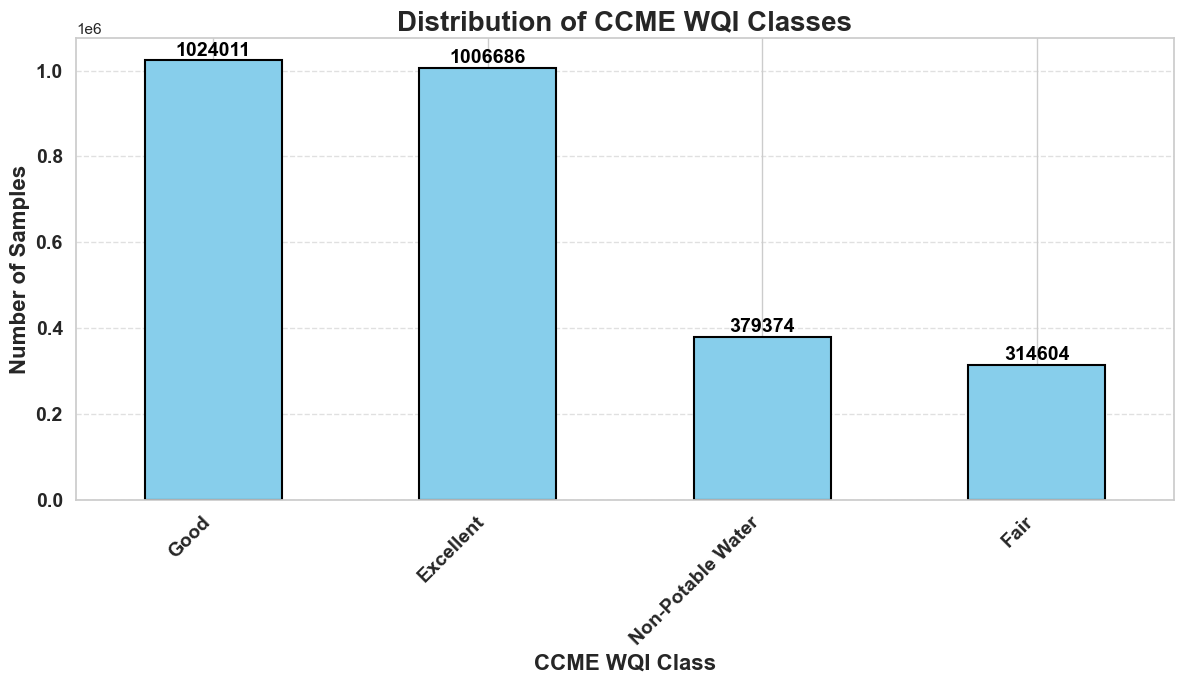

In [ ]:
distribution = df_clean["CCME_WQI"].value_counts()
plt.figure(figsize=(12, 7))  
ax = distribution.plot(
    kind="bar",
    color="skyblue",
    edgecolor="black",
    linewidth=1.5
)
ax.set_title(
    "Distribution of CCME WQI Classes",
    fontsize=20,
    fontweight="bold"
)
ax.set_xlabel("CCME WQI Class", fontsize=16, fontweight="bold")
ax.set_ylabel("Number of Samples", fontsize=16, fontweight="bold")
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
for label in ax.get_xticklabels():
    label.set_fontweight("bold")
    label.set_rotation(45)
    label.set_ha("right")
for label in ax.get_yticklabels():
    label.set_fontweight("bold")

for i, v in enumerate(distribution.values):
    ax.text(
        i, v + max(distribution.values)*0.01,   
        str(v),
        ha='center',
        fontsize=14,
        fontweight='bold',
        color='black'
    )
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
 
df_clean['Waterbody Type'] = df_clean['Waterbody Type'].replace({
    'Marine': 'Coastal/Marine',
    'Sea Water': 'Coastal/Marine',
    'Coastal': 'Coastal/Marine',
    'Estuarine': 'Coastal/Marine',
    'Sewage': 'Wastewater',
    'Effluent': 'Wastewater',
    'Canal': 'Artificial',
    'Drainage': 'Artificial',
    'Bay': 'Minor Waterbodies',
    'Artificial': 'Minor Waterbodies',
    'Transitional': 'Minor Waterbodies'
})
 
df_encoded = pd.get_dummies(df_clean, columns=['Waterbody Type'],dtype="int")

C:\Users\O\AppData\Local\Temp\ipykernel_13244\705561465.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Waterbody Type'] = df_clean['Waterbody Type'].replace({


In [ ]:
df_clean['Waterbody Type'].value_counts()

Waterbody Type
River                1819056
Wastewater            567289
Lake                  146316
Coastal/Marine        105160
Minor Waterbodies      49613
Artificial             37241
Name: count, dtype: int64

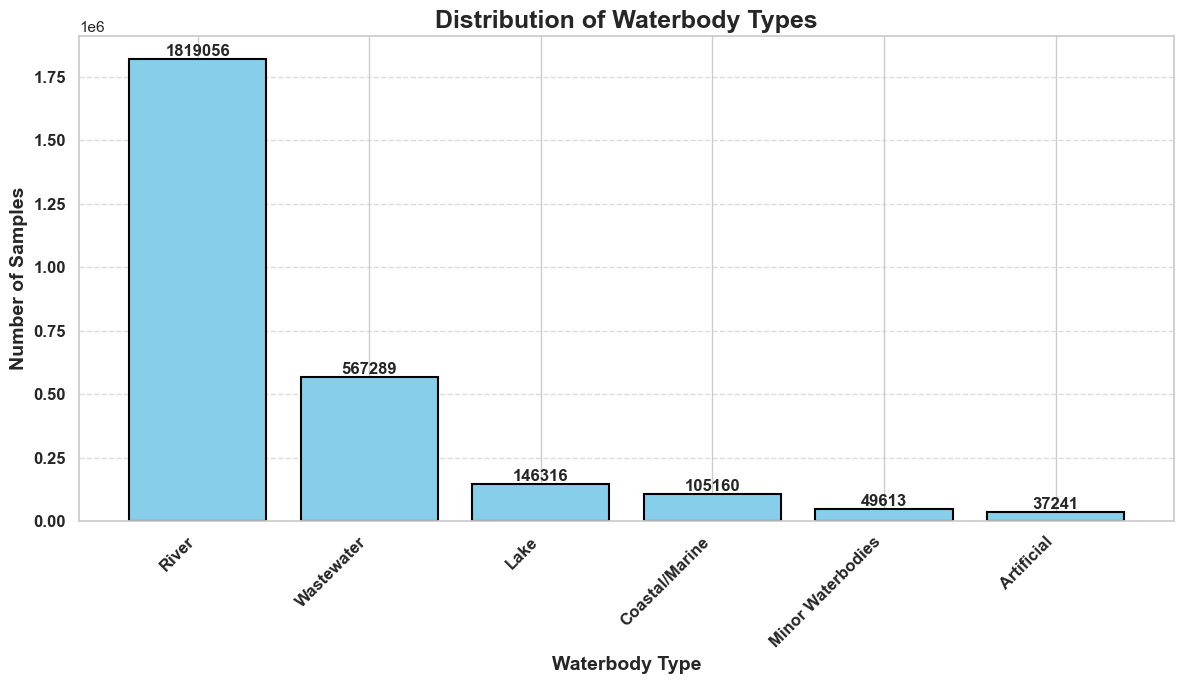

In [ ]:
distribution = df_clean['Waterbody Type'].value_counts()
plt.figure(figsize=(12, 7))
bars = plt.bar(distribution.index, distribution.values, color='skyblue', edgecolor='black', linewidth=1.5)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{yval}", 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Distribution of Waterbody Types', fontsize=18, fontweight='bold')
plt.xlabel('Waterbody Type', fontsize=14, fontweight='bold')
plt.ylabel('Number of Samples', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

 

In [ ]:
df_encoded

,Country,Area,Date,Ammonia (mg/l),Biochemical Oxygen Demand (mg/l),Dissolved Oxygen (mg/l),Orthophosphate (mg/l),pH (ph units),Temperature (cel),Nitrogen (mg/l),...,CCME_Values,CCME_WQI,Year,Month,Waterbody Type_Artificial,Waterbody Type_Coastal/Marine,Waterbody Type_Lake,Waterbody Type_Minor Waterbodies,Waterbody Type_River,Waterbody Type_Wastewater
0,Canada,SE649035-145565,1974-01-12,0.059248,1.30,8.1500,0.011917,8.07500,9.885,0.343917,...,100.0,Excellent,1974,1,0,0,0,0,1,0
1,Canada,SE649035-145565,1975-01-12,0.039821,1.38,7.8000,0.009417,7.73333,10.150,0.449083,...,100.0,Excellent,1975,1,0,0,0,0,1,0
2,Canada,SE649035-145565,1976-01-12,0.031341,2.23,7.8000,0.011000,7.46667,10.235,0.220750,...,100.0,Excellent,1976,1,0,0,0,0,1,0
3,Canada,SE649035-145565,1977-01-12,0.020501,1.61,8.1500,0.012333,7.78333,11.116,0.572250,...,100.0,Excellent,1977,1,0,0,0,0,1,0
4,Canada,SE649035-145565,1978-01-12,0.020023,1.64,4.3708,0.006182,7.10000,7.068,0.371091,...,100.0,Excellent,1978,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2827972,Ireland,"Cork Harbour, Moy Killala, YELLOW (KNOCK)_020",2022-06-21,0.024000,1.40,4.2930,0.025000,7.90000,16.200,0.370000,...,100.0,Excellent,2022,6,0,0,0,0,1,0
2827973,Ireland,"Cork Harbour, Moy Killala, YELLOW (KNOCK)_020",2022-09-28,0.038000,1.40,4.4955,0.025000,7.90000,11.400,0.540000,...,100.0,Excellent,2022,9,0,0,0,0,1,0
2827974,Ireland,"Cork Harbour, Moy Killala, YELLOW (KNOCK)_020",2022-11-29,0.035000,1.40,4.4640,0.016000,7.60000,6.200,0.800000,...,100.0,Excellent,2022,11,0,0,0,0,1,0
2827975,Ireland,"Cork Harbour, Moy Killala, YELLOW (KNOCK)_020",2023-02-07,0.046000,1.40,4.1760,0.012000,8.00000,7.800,0.950000,...,100.0,Excellent,2023,2,0,0,0,0,1,0


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class_order = ["Non-Potable Water", "Fair", "Good", "Excellent"]
cat_type = pd.CategoricalDtype(categories=class_order, ordered=True)
y = df_encoded["CCME_WQI"]
y_int = y.astype(cat_type).cat.codes.values

print("class_order, cat_type, device were successfully defined")
print(f"Number of categories:{len(class_order)}")
print(f"Distribution of primary categories: \n{pd.Series(y_int).value_counts()}")

Using device: cuda
تم تعريف class_order, cat_type, device بنجاح
عدد الفئات: 4
توزيع الفئات الأولي:
2    1024011
3    1006686
0     379374
1     314604
Name: count, dtype: int64


In [ ]:

df_encoded['Date'] = pd.to_datetime(df_encoded['Date'], dayfirst=True, errors='coerce')
df_encoded = df_encoded.sort_values(by=['Area', 'Date']).reset_index(drop=True)
unique_areas = df_encoded['Area'].unique()
np.random.seed(42) 
np.random.shuffle(unique_areas)
train_size = int(len(unique_areas) * 0.7)
val_size   = int(len(unique_areas) * 0.15)

train_areas = unique_areas[:train_size]
val_areas   = unique_areas[train_size:train_size + val_size]
test_areas  = unique_areas[train_size + val_size:]

df_train_final = df_encoded[df_encoded['Area'].isin(train_areas)].copy()
df_val_final   = df_encoded[df_encoded['Area'].isin(val_areas)].copy()
df_test_final  = df_encoded[df_encoded['Area'].isin(test_areas)].copy()

print(f"Training: {len(df_train_final)} records  ({len(train_areas)} areas)")
print(f" Validation: {len(df_val_final)} records  ({len(val_areas)} areas)")
print(f" Testing: {len(df_test_final)} records  ({len(test_areas)} areas)")

 
def extract_X_y(df):
    X_df = df.drop(columns=["CCME_WQI", "Country", "Area", "Date", "Year", "CCME_Values"])
    y_df = df["CCME_WQI"].astype(cat_type).cat.codes.values
    return X_df, y_df

X_train, y_train = extract_X_y(df_train_final)
X_val,   y_val   = extract_X_y(df_val_final)
X_test,  y_test  = extract_X_y(df_test_final)

 
X_train.columns = [col.replace(' ', '_').replace('/', '_').replace('(', '').replace(')', '') for col in X_train.columns]
X_val.columns   = X_train.columns
X_test.columns  = X_train.columns
 
num_features = ["Ammonia_mg_l", "Biochemical_Oxygen_Demand_mg_l", "Dissolved_Oxygen_mg_l", 
                "Orthophosphate_mg_l", "pH_ph_units", "Temperature_cel", 
                "Nitrogen_mg_l", "Nitrate_mg_l"]
cat_features = [col for col in X_train.columns if col not in num_features]

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('pw', PowerTransformer(method='yeo-johnson')),
        ('sc', StandardScaler())
    ]), num_features),
    ('cat', 'passthrough', cat_features)
])

X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc   = preprocessor.transform(X_val)
X_test_proc  = preprocessor.transform(X_test)

✅ التدريب: 1931177 سجل (42019 منطقة)
✅ التحقق: 390568 سجل (9004 منطقة)
✅ الاختبار: 402930 سجل (9005 منطقة)


In [ ]:
def create_sequences_fast(X_proc, y_data, areas_df, seq_length=5,stride=3):
    all_x, all_y = [], []
    areas_values = areas_df['Area'].values
    y_values = y_data.values if hasattr(y_data, 'values') else y_data
    unique_areas = areas_df['Area'].unique()
    pbar = tqdm(unique_areas, desc="Creating Augmented Sequences", unit="area")
    
    for area in pbar:
        mask = (areas_values == area)
        X_area = X_proc[mask]
        y_area = y_values[mask]
        
        if len(X_area) > seq_length:
            for start in range(0, len(X_area) - seq_length + 1, stride):
                all_x.append(X_area[start:start + seq_length])
                all_y.append(y_area[start + seq_length - 1])
    
    pbar.close()
    return np.array(all_x, dtype=np.float32), np.array(all_y, dtype=np.int64)
 
print("Starting sequence generation...")

start_time = time.time()

X_train_seq, y_train_seq = create_sequences_fast(
    X_train_proc, y_train, df_train_final, 
    seq_length=8,   
    stride=4       
)

X_val_seq, y_val_seq = create_sequences_fast(
    X_val_proc, y_val, df_val_final, 
    seq_length=8, 
    stride=1        
)

X_test_seq, y_test_seq = create_sequences_fast(
    X_test_proc, y_test, df_test_final, 
    seq_length=8, 
    stride=1       
)

print(f"Conversion completed in {time.time() - start_time:.2f} seconds")

class_weights_np = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_seq),
    y=y_train_seq
)
class_weights = torch.tensor(class_weights_np, dtype=torch.float32).to(device)

print("\nFinal class weights:")

for cls_idx, w in enumerate(class_weights):
    print(f"الفئة {cls_idx} ({class_order[cls_idx]}): {w:.4f}")

Starting sequence generation...


Creating Augmented Sequences:   2%|▏         | 1046/42019 [00:43<27:24, 24.91area/s]

In [ ]:
X_train_t = torch.FloatTensor(X_train_seq).to(device)
y_train_t = torch.LongTensor(y_train_seq).to(device)
X_val_t = torch.FloatTensor(X_val_seq).to(device)
y_val_t = torch.LongTensor(y_val_seq).to(device)
X_test_t = torch.FloatTensor(X_test_seq).to(device)
y_test_t = torch.LongTensor(y_test_seq).to(device)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=64, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ================================================================
# 1) Date-Driven Positional Embedding (من الورقة - مقالة 3.2)
# ================================================================
class DateDrivenPositionalEmbedding(nn.Module):
    """
    من الورقة Section 3.2:
    "Date-driven positional embedding approach specifically tailored 
    for water quality data prediction"
    
    المعادلات من الورقة:
    y(t,2i) = sin(year(t)/10000^(2i/dm))
    y(t,2i+1) = cos(year(t)/10000^(2i+1/dm))
    w = y + m + d + h
    """
    def __init__(self, d_model=64):
        super().__init__()
        self.d_model = d_model
        
    def forward(self, x, time_comps=None):
        """
        x: (batch, seq_len, d_model) - للحصول على الشكل والـ device
        time_comps: (batch, seq_len, 4) -> [year, month, day, hour]
        
        Output: (batch, seq_len, d_model)
        """
        batch_size, seq_len, _ = x.shape
        
        if time_comps is not None:
            pe = torch.zeros(batch_size, seq_len, self.d_model, 
                            device=x.device, dtype=x.dtype)
            
            # div_term من المعادلة
            div_term = torch.exp(
                torch.arange(0, self.d_model, 2, device=x.device, 
                           dtype=x.dtype) * (-np.log(10000.0) / self.d_model)
            )
            
            # معالجة 4 مكونات: year, month, day, hour
            for i in range(min(4, time_comps.shape[-1])):
                comp = time_comps[:, :, i].float()
                # y(t,2i) = sin(comp * div_term)
                pe[:, :, 0::2] += torch.sin(comp.unsqueeze(-1) * div_term)
                # y(t,2i+1) = cos(comp * div_term)
                if self.d_model % 2 == 1:
                    pe[:, :, 1::2] += torch.cos(comp.unsqueeze(-1) * div_term[:-1])
                else:
                    pe[:, :, 1::2] += torch.cos(comp.unsqueeze(-1) * div_term)
            
            # تطبيع المجموع (w = y + m + d + h)
            return pe / 4.0
        else:
            # Fallback: standard positional encoding
            pe = torch.zeros(batch_size, seq_len, self.d_model, 
                           device=x.device, dtype=x.dtype)
            pos = torch.arange(seq_len, dtype=x.dtype, device=x.device).unsqueeze(1)
            
            div_term = torch.exp(
                torch.arange(0, self.d_model, 2, device=x.device, 
                           dtype=x.dtype) * (-np.log(10000.0) / self.d_model)
            )
            
            pe[:, :, 0::2] = torch.sin(pos * div_term).unsqueeze(0)
            if self.d_model % 2 == 1:
                pe[:, :, 1::2] = torch.cos(pos * div_term[:-1]).unsqueeze(0)
            else:
                pe[:, :, 1::2] = torch.cos(pos * div_term).unsqueeze(0)
            
            return pe


# ================================================================
# 2) Pearson Correlation Attention (من الورقة - مقالة 3.1)
# ================================================================
class CorrelationAttention(nn.Module):
    """
    من الورقة Section 3.1:
    "Correlation self-attention mechanism" using Pearson correlation
    
    الخطوات من الورقة:
    1. Sliding window بـ length l
    2. حساب Pearson correlation: r'_{j,k}
    3. Max pooling لاختيار أقوى الارتباطات
    4. تطبيق softmax(correlation) على الـ values
    
    المعادلات:
    r'_{j,k} = Σ(x'_t * x'_{t+k}) / Σ(x'_t^2)  (معادلة 8 في الورقة)
    Correlation(Q', K', V') = softmax([diag(Q'_sd K'^T_sd)]^{-1}[Q'_sd K'^T_sd] / √l) V'
    """
    def __init__(self, window_size=4, dropout=0.1):
        super().__init__()
        self.window_size = window_size
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        """
        Input:  x: (batch, seq_len, d_model)
        Output: (batch, seq_len, d_model)
        
        تطبيق دقيق لـ Correlation block من الورقة
        """
        batch_size, seq_len, d_model = x.shape
        w = self.window_size
        
        if seq_len < w:
            return x
        
        # Step 1: Normalize البيانات (z-score) - من معادلة 8
        x_mean = x.mean(dim=1, keepdim=True)  # (batch, 1, d_model)
        x_std = x.std(dim=1, keepdim=True) + 1e-8
        x_norm = (x - x_mean) / x_std  # (batch, seq_len, d_model)
        
        # Step 2: Sliding window - من الورقة معادلة 9
        x_t = x_norm.transpose(1, 2)  # (batch, d_model, seq_len)
        windows = x_t.unfold(2, w, 1)  # (batch, d_model, seq_len-w+1, w)
        
        # إعادة تشكيل: (batch, d_model, num_windows, w) → (batch, num_windows, d_model, w)
        windows = windows.permute(0, 2, 1, 3)
        batch_size, num_windows, d_model, w_size = windows.shape
        
        # Step 3: حساب Pearson correlation matrix لكل window - من معادلة 8
        # r'_{j,k} = Σ(x'_t * x'_{t+k}) / Σ(x'_t^2)
        
        # X'_sd * X'^T_sd (معادلة 10 في الورقة)
        corr_matrix = torch.matmul(
            windows,  # (batch, num_windows, d_model, w)
            windows.transpose(-2, -1)  # (batch, num_windows, w, d_model)
        ) / w_size  # تطبيع بـ w
        
        # Step 4: تطبيق diag normalization - من معادلة 11
        diag_vals = torch.diagonal(corr_matrix, dim1=-2, dim2=-1)  # (batch, num_windows, d_model)
        diag_inv = 1.0 / (diag_vals.unsqueeze(-1) + 1e-8)
        
        # Normalize correlation matrix
        corr_normalized = corr_matrix * diag_inv  # (batch, num_windows, d_model, d_model)
        
        # Step 5: Max pooling لاختيار أقوى الارتباطات - من الورقة
        corr_strength = corr_normalized.abs().max(dim=-1)[0]  # (batch, num_windows, d_model)
        
        # Step 6: توسيع النتيجة من num_windows إلى seq_len مع averaging
        output = torch.zeros(batch_size, seq_len, d_model, 
                            device=x.device, dtype=x.dtype)
        counts = torch.zeros(batch_size, seq_len, 1, 
                            device=x.device, dtype=x.dtype)
        
        for i in range(num_windows):
            start_idx = i
            end_idx = i + w_size
            
            # تطبيق أوزان الارتباط على الـ original data
            weighted = x[:, start_idx:end_idx, :] * \
                      corr_strength[:, i:i+1, :].unsqueeze(1)
            
            output[:, start_idx:end_idx, :] += weighted
            counts[:, start_idx:end_idx, :] += 1
        
        # Normalize بـ counts
        output = output / (counts + 1e-8)
        
        output = self.dropout(output)
        return output


# ================================================================
# 3) Correlation Layer (من الورقة - Algorithm 1)
# ================================================================
class CorrelationLayer(nn.Module):
    """
    من الورقة Algorithm 1:
    "LayerNorm → Correlation Attention → FFN → LayerNorm"
    
    مع Residual Connections و Dropout للتنظيم
    """
    def __init__(self, d_model, dim_feedforward=256, 
                 window_size=4, dropout=0.1):
        super().__init__()
        
        # Pre-normalization (من الورقة)
        self.norm1 = nn.LayerNorm(d_model)
        self.corr_attn = CorrelationAttention(window_size, dropout)
        
        self.norm2 = nn.LayerNorm(d_model)
        
        # Feed-forward network (من معادلة 17 في الورقة)
        # FFN(X'_co) = max(0, X'_co*W1 + b1)*W2 + b2
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),  # max(0, ...)
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model),
            nn.Dropout(dropout)
        )
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        """
        x: (batch, seq_len, d_model)
        return: (batch, seq_len, d_model)
        
        من Algorithm 1:
        1. X' = LayerNorm(X)
        2. Calculate Correlation attention
        3. X'_co = LayerNorm(X'_co + FFN(X'_co))
        """
        # Correlation attention مع residual
        attn_out = self.corr_attn(self.norm1(x))
        x = x + self.dropout(attn_out)
        
        # Feed-forward مع residual
        ffn_out = self.ffn(self.norm2(x))
        x = x + self.dropout(ffn_out)
        
        return x


# ================================================================
# 4) LWQformer Classification Model (من الورقة)
# ================================================================
class LWQformer(nn.Module):
    """
    LWQformer من الورقة مع تعديل للتصنيف بدل التنبؤ
    
    Architecture:
    1. Input Embedding (Linear)
    2. Date-Driven Positional Embedding (المعادلات 14-16)
    3. Multiple Correlation Layers (Algorithm 1)
    4. Global Average Pooling
    5. Classification Head (MLP)
    """
    def __init__(
        self,
        input_dim,
        d_model=64,
        num_layers=1,           # الورقة تستخدم 1 layer
        dim_feedforward=256,
        num_classes=4,
        window_size=5,          # من الورقة
        dropout=0.1,
    ):
        super().__init__()
        
        self.input_dim = input_dim
        self.d_model = d_model
        
        # ========== Step 1: Input Embedding ==========
        # من الورقة: X = X + PositionalEmbedding(T)
        self.embed = nn.Linear(input_dim, d_model)
        
        # ========== Step 2: Date-Driven Positional Embedding ==========
        # من الورقة Section 3.2
        self.pos_embed = DateDrivenPositionalEmbedding(d_model)
        
        # ========== Step 3: Correlation Layers ==========
        # من الورقة Algorithm 1
        self.layers = nn.ModuleList([
            CorrelationLayer(d_model, dim_feedforward, 
                           window_size, dropout)
            for _ in range(num_layers)
        ])
        
        # ========== Step 4: Classification Head ==========
        # من الورقة Section 3.4: MLP للتنبؤ
        # تعديل: بدل التنبؤ، نستخدم للتصنيف
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )
        
    def forward(self, x, time_comps=None):
        """
        x: (batch, seq_len, input_dim)
        time_comps: (batch, seq_len, 4) optional - التواريخ
        return: (batch, num_classes)
        
        From Algorithm 1:
        1. X = X + PositionalEmbedding(T)
        2. For each layer:
           - X' = LayerNorm(X)
           - Calculate Correlation attention
           - X = X + FFN(X)
        3. Output: Classification
        """
        # Step 1: Embedding
        x = self.embed(x)  # (batch, seq_len, d_model)
        
        # Step 2: Add positional embedding
        pos_emb = self.pos_embed(x, time_comps)  # (batch, seq_len, d_model)
        x = x + pos_emb
        
        # Step 3: Pass through correlation layers
        for layer in self.layers:
            x = layer(x)  # (batch, seq_len, d_model)
        
        # Step 4: Global average pooling لتحويل من (batch, seq_len, d_model) 
        # إلى (batch, d_model)
        x = x.transpose(1, 2)  # (batch, d_model, seq_len)
        x = self.global_pool(x)  # (batch, d_model, 1)
        x = x.squeeze(-1)  # (batch, d_model)
        
        # Step 5: Classification
        logits = self.classifier(x)  # (batch, num_classes)
        
        return logits



In [ ]:
input_size = X_train_seq.shape[2]  # عدد الـ features
seq_length = X_train_seq.shape[1]  # طول السلسلة (8)
num_classes = len(class_order)  


 

In [ ]:
model = LWQformer(
    input_dim=input_size,
    d_model=128,
    num_layers=2,
    dim_feedforward=512,
    num_classes=num_classes,
    window_size=4,
    dropout=0.15,
    use_fast_attention=True
).to(device)

num_params = sum(p.numel() for p in model.parameters())
print(f"\n🧠 Model Parameters: {num_params:,}")

# ✅ حساب Class Weights من البيانات
unique_classes, class_counts = np.unique(y_train_seq, return_counts=True)
total_samples = len(y_train_seq)

class_weights_np = total_samples / (num_classes * class_counts + 1e-8)
class_weights_np = class_weights_np / class_weights_np.max()

class_weights = torch.tensor(class_weights_np, dtype=torch.float32).to(device)

print(f"\n⚖️ Class Weights:")
for i, (cls_idx, count) in enumerate(zip(unique_classes, class_counts)):
    weight = class_weights[cls_idx].item()
    percentage = (count / total_samples) * 100
    print(f"   {class_order[cls_idx]:20s}: Count={count:4d} ({percentage:5.1f}%) | Weight={weight:.4f}")

# ✅ Loss Function
criterion = nn.CrossEntropyLoss(weight=class_weights)

# ✅ Optimizer (AdamW - الأفضل للـ Transformers)
optimizer = optim.AdamW(
    model.parameters(), 
    lr=5e-4,              # Learning rate
    weight_decay=1e-5     # L2 regularization
)

# ✅ Learning Rate Scheduler (بناءً على Balanced Accuracy)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max',           # ✅ maximize Balanced Accuracy
    factor=0.5, 
    patience=5, 
    verbose=True,
    cooldown=2,
    min_lr=1e-7
)

print(f"\n⚙️ Optimizer Setup:")
print(f"   Optimizer: AdamW")
print(f"   Learning Rate: 5e-4")
print(f"   Weight Decay: 1e-5")
print(f"   Scheduler: ReduceLROnPlateau (mode='max' on Balanced Accuracy)")

# ================================================================
# 2) Training Parameters
# ================================================================
num_epochs = 50           # ✅ عدد العصور
patience = 15             # ✅ Early stopping patience
min_delta = 0.001         # ✅ أقل تحسن مقبول (0.1% في Balanced Accuracy)
gradient_clip = 1.0       # ✅ Gradient clipping

print(f"\n🎯 Training Parameters:")
print(f"   Number of Epochs: {num_epochs}")
print(f"   Early Stopping Patience: {patience}")
print(f"   Min Delta (improvement threshold): {min_delta:.4f}")
print(f"   Gradient Clip Value: {gradient_clip}")

# ================================================================
# 3) Training History
# ================================================================
train_losses = []
train_accs = []
train_bal_accs = []
val_losses = []
val_accs = []
val_bal_accs = []
learning_rates = []

best_val_bal_acc = 0.0
patience_counter = 0
best_model_state = None

# ================================================================
# 4) Main Training Loop
# ================================================================
print("\n" + "="*120)
print(f"{'Epoch':<8} | {'Train Loss':<12} | {'Train Acc':<12} | {'Train Bal.Acc':<14} | "
      f"{'Val Loss':<12} | {'Val Acc':<12} | {'Val Bal.Acc':<14} | {'LR':<10}")
print("-"*120)

for epoch in range(num_epochs):
    # ==================== TRAINING ====================
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    train_preds = []
    train_targets = []

    # Progress bar
    loop = tqdm(train_loader, leave=False, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch_x, batch_y in loop:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # ✅ Forward pass
        logits = model(batch_x)
        loss = criterion(logits, batch_y)

        # ✅ Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # ✅ Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip)
        
        optimizer.step()

        # ✅ Track metrics
        train_loss += loss.item() * batch_y.size(0)
        preds = torch.argmax(logits, dim=1)
        train_correct += (preds == batch_y).sum().item()
        train_total += batch_y.size(0)

        train_preds.extend(preds.cpu().numpy())
        train_targets.extend(batch_y.cpu().numpy())

        loop.set_postfix({'loss': f'{loss.item():.4f}'})

    # ✅ Calculate training metrics
    train_loss /= train_total
    train_acc = 100 * train_correct / train_total
    train_bal_acc = 100 * balanced_accuracy_score(train_targets, train_preds)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_bal_accs.append(train_bal_acc)

    # ==================== VALIDATION ====================
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_preds = []
    val_targets = []

    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            logits = model(batch_x)
            loss = criterion(logits, batch_y)

            val_loss += loss.item() * batch_y.size(0)
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == batch_y).sum().item()
            val_total += batch_y.size(0)

            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(batch_y.cpu().numpy())

    # ✅ Calculate validation metrics
    val_loss /= val_total
    val_acc = 100 * val_correct / val_total
    val_bal_acc = 100 * balanced_accuracy_score(val_targets, val_preds)

    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_bal_accs.append(val_bal_acc)

    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # ✅ Print epoch results
    print(f"{epoch+1:<8} | {train_loss:<12.4f} | {train_acc:<12.2f} | {train_bal_acc:<14.2f} | "
          f"{val_loss:<12.4f} | {val_acc:<12.2f} | {val_bal_acc:<14.2f} | {current_lr:<10.6f}")

    # ==================== LEARNING RATE SCHEDULING ====================
    # ✅ Schedule بناءً على Balanced Accuracy
    scheduler.step(val_bal_acc)

    # ==================== EARLY STOPPING ====================
    if val_bal_acc > best_val_bal_acc + min_delta:
        best_val_bal_acc = val_bal_acc
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        print(f"  ✅ Saved best model! (Val Bal.Acc: {val_bal_acc:.2f}%)")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\n⏸️ Early Stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
            break

print("="*120)
print(f"✅ Best Validation Balanced Accuracy: {best_val_bal_acc:.2f}%")
print("✅ Training finished!")

 